In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from prettytable import PrettyTable

In [2]:
x = sp.symbols('x')
bounds = [-1, 1]

# РЕШЕНИЕ КРАЕВЫХ ЗАДАЧ МЕТОДОМ РАЗНОСТНЫХ АППРОКСИМАЦИЙ

## Теория

Рассматриваем уравнение вида:

$$
t(x)\cdot y'' + p(x) \cdot y' + q(x) \cdot y = f(x)
$$

$$
t(x), p(x), q(x), f(x) - непрерывные \ на\  отрезке\  [a, b]\ функции
$$

### Условия для базисной системы

1. $\phi_{0}$ удовлетворяет граничному условию
2. функции $\phi_{1}(x), ..., \phi_{n}(x)$ - линейно независимы на [a, b] и удовлетворяют однородным граничным условиям

Тогда по базисным функция строим приближенное решение в виде линейной комбинации базисный функций:

$$
y_{n} = \phi_{0}(x) + a_{1}*\phi_{1}(x) + ... + a_{n}*\phi_{n}(x)
$$

Задача сводится к выбору $a_{1}, ..., a_{n}$ таких, чтобы $y_{n}(x)$ удовлетворяла граничному условию и приближалась к граничному решению.

Выражение:

$$
\psi(x, a_{1}, ..., a_{n}) = t(x) \cdot y_{n}(x)'' + p(x) \cdot y_{n}(x)' + q(x) \cdot y_{n}(x) - f(x)
$$

Называется невязкой

Базисные функции вида:

$$
x^{i} \cdot (1 - x^2)
$$

In [3]:
def create_base_system(t, p, q, f):
    n = int(input("Введите количество базисных функций: "))
    coefs = sp.symbols('a1:%s' % (n+1))
    base_system = [x**i * (1 - x**2) for i in range(n)]
    return n, coefs, base_system

## Способы решение краевой задачи

### Метод коллокаций

На отрезке $[a, b]$ выбирается $m$ точек $x_{1}, ..., x_{n}$ $(m \geq n)$

Эти точки последовательно подставляются в невязку, считаю, что она должна быть равна `0`

Обычно берётся `m = n` и решается система из `n` уравнений и `n` неизвестных

In [4]:
def collocation_method(n, psi, coefs, *args):
    # m = int(input('Введите количество точек для метода коллокаций (>= %s)' % n))
    points = np.linspace(*bounds, n + 2)
    psi_func = sp.lambdify(x, psi)
    system = [
        psi_func(i) for i in points[1:-1]
    ]
    return sp.solve(system, coefs)

### Интегральный МНК

Для нахождения коффициентов при базисных функциях минимизируется интеграл:

$$
I = \int_a^b \phi^2(x, a_1, ..., a_n)dx
$$

Для нахождения минимума интеграла решаем систему:

$$
\frac{dI}{d a_1} = 2 \int_a^b \psi(x, a_1, ..., a_n) \frac{d \psi(x, a_1, ..., a_n)}{da_1}dx = 0
$$
$$
...............................................
$$
$$
\frac{dI}{d a_n} = 2 \int_a^b \psi(x, a_1, ..., a_n) \frac{d \psi(x, a_1, ..., a_n)}{d a_n}dx = 0
$$

In [5]:
def integral_LSM_method(n, psi, coefs, *args):
    system = [
        sp.integrate(psi * psi.diff(ai), (x, *bounds)) for ai in coefs
    ]
    return sp.solve(system, coefs)

### Дискретный МНК

Выбирается $N > n$ точек и решается задача минимизации:

$$
S = \sum_{i=1}^{N}\psi^2(x_i, a_1, ..., a_n)
$$

Для её решение решается система:

$$
\frac{dS}{d a_1} = 0
$$
$$
.......
$$
$$
\frac{dS}{d a_n} = 0
$$

In [6]:
def discrete_LSM_method(n, psi, coefs, *args):
    points_amount = int(input('Введите количество точек для дискретного МНК(> %s): ' % n))
    points = np.linspace(*bounds, points_amount + 2)
    S = sum(psi.subs(x, i)**2 for i in points[1:-1])
    system = [
        S.diff(ai) for ai in coefs
    ]
    return sp.solve(system, coefs)

### Метод Галёркина

Рассматриваем невязку $\psi$ и для определения коэффициентов $a_1, ..., a_n$ решаем систему:


$$
\int_a^b\psi(x, a_1, ..., a_n)\cdot \psi_1(x)dx = 0
$$
$$
................................
$$
$$
\int_a^b\psi(x, a_1, ..., a_n)\cdot \psi_n(x)dx = 0
$$


In [7]:
def galerkin_method(n, psi, coefs, base_system):
    system = [
        sp.integrate(psi * base_system[i], (x, *bounds)) for i in range(n)
    ]
    return sp.solve(system, coefs)

## Solver

In [8]:
def solver(t, p, q, f):
    solvers = [collocation_method, discrete_LSM_method, galerkin_method]
    
    # создание базисный фукнций
    n, coefs, base_system = create_base_system(t, p, q, f)
    
    # создание аппроксимации y и выражениия пси
    yn = reduce(lambda acc, t: acc + t[0]*t[1], zip(coefs, base_system), 0)
    psi = t * yn.diff(x, x) + p * yn.diff(x) + q * yn - f
    
    # создание таблицы
    table = PrettyTable()
    table.field_names = ['Name', 'max(y)'] + ['a%s' % (i + 1) for i in range(n)]
    
    # решение задачи (нахождение коэффициентов)
    for func in solvers:
        answer = func(n, psi, coefs, base_system)
        # print('Answer',answer)
        
        y = sp.lambdify(x, yn.subs(answer))
        xs = np.linspace(*bounds)
        ys = np.array([y(i) for i in xs])
        plt.plot(xs, ys, label=func.__name__)
        
        table.add_row([func.__name__, round(max(ys), 3), *list(map(lambda x: round(x, 6),answer.values()))])
        
    plt.grid()
    plt.legend()
    plt.show()
    print(table)

Введите количество базисных функций: 5
Введите количество точек для дискретного МНК(> 5): 25


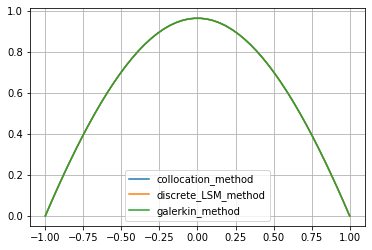

+---------------------+--------+----------+------+-----------+-----+----------+
|         Name        | max(y) |    a1    |  a2  |     a3    |  a4 |    a5    |
+---------------------+--------+----------+------+-----------+-----+----------+
|  collocation_method | 0.965  | 0.964956 | 0.0  | -0.115524 | 0.0 | 0.019974 |
| discrete_LSM_method | 0.964  | 0.964467 | -0.0 |  -0.11518 | 0.0 | 0.01834  |
|   galerkin_method   | 0.964  | 0.964474 | 0.0  | -0.115334 | 0.0 | 0.018544 |
+---------------------+--------+----------+------+-----------+-----+----------+


In [9]:
solver(np.sin(2), 0, 1 + np.cos(2) * x**2, -1)